In [2]:
!pip install jiwer

In [3]:
!pip install scikeras

# Load libraries

In [1]:
import re
import os
import subprocess
import tarfile
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from jiwer import wer
import matplotlib.pyplot as plt

# Data directories

In [2]:
# Path to the extracted data directory
data_dir = "datasets/akan"

# Now you can access the required files in your code
metadata_path = data_dir + "/selected_transcribed_audios.xlsx"

# Load the akan dataset

In [3]:
# I couldn't download all mp3 files at a go. This is a simple function to ensure I get transacribed audios only for mp3 files download. 
# You must run this function irrespective whether you have all files or not.
def get_converted_mp3_files(mp3_dir):
    converted_files = []
    for filename in os.listdir(mp3_dir):
        if filename.endswith(".mp3"):
            converted_files.append(filename)  # Store the name of the converted file
    return converted_files

# Convert MP3 to WAV and get the list of converted file names
converted_files = get_converted_mp3_files(data_dir)

# Create a DataFrame with the list of converted file names
mp3_df = pd.DataFrame({"Full Filename": converted_files})

In [4]:
# Function to remove all punctuation marks except for apostrophes, exclamation marks, and question marks
def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s\'?!]', '', text.lower())
    return cleaned_text

In [5]:
def load_dataset(data_csv, test_size=0.1, val_size=0.1, random_state=42):
    tem_df = pd.read_excel(data_csv)
    tem_df = tem_df[['Full Filename', 'Transcriptions']]

    # Perform inner join based on 'filename'
    df = pd.merge(mp3_df, tem_df, on='Full Filename')

    # Remove leading " from each value in the column
    # df['file_name'] = df['file_name'].str.strip('"')

    # Clean normalized_transcription column
    df['Transcriptions'] = df['Transcriptions'].apply(clean_text)

    df = df.sample(frac=1).reset_index(drop=True)

    # Drop rows with missing values in 'normalized_transcription' column
    # df = df.dropna(subset=['normalized_transcription'])

    train_files, test_files, train_texts, test_texts = train_test_split(
        df['Full Filename'], df['Transcriptions'], test_size=test_size, random_state=random_state
    )

    train_files, val_files, train_texts, val_texts = train_test_split(
        train_files, train_texts, test_size=val_size, random_state=random_state
    )
    return train_files, val_files, test_files, train_texts, val_texts, test_texts

In [6]:
# Create dataset
train_files, val_files, test_files, train_texts, val_texts, test_texts = load_dataset(metadata_path)

# Audio Pre-processing

In [7]:
def extract_features(audio_files, sr=22050, n_mfcc=13, max_length=1191):
    features = []
    for file in audio_files:
        file_path = os.path.join(data_dir, file)
        if os.path.exists(file_path):
          # print(f"WAV file exist: {wav_file_path}")
          # print("")
          audio, _ = librosa.load(file_path, sr=sr)
          mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
          # print("max_length", max_length)
          # print("mfcc", mfcc.shape[1])
          # print("file", file)
          # Pad or truncate the features to a fixed length
          padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
          features.append(padded_mfcc.T)  # Transpose to have time along the first axis
        else:
          pass
    return features


train_features = extract_features(train_files)
val_features = extract_features(val_files)
test_features = extract_features(test_files)

# Text Pre-processing

In [8]:
# Clean the transcriptions
cleaned_train_texts = [clean_text(text) for text in train_texts]
cleaned_val_texts = [clean_text(text) for text in val_texts]
cleaned_test_texts = [clean_text(text) for text in test_texts]

In [9]:
def create_tokenizer(texts):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>")
    tokenizer.fit_on_texts(texts)
    return tokenizer


def tokenize_text(tokenizer, texts, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding="post"
    )
    return padded_sequences

# Step 3: Create Vocabulary
tokenizer = create_tokenizer(cleaned_train_texts + cleaned_val_texts + cleaned_test_texts)
vocab_size = len(tokenizer.word_index) + 1

# Step 4: Convert Text to Numerical Representations
max_text_length = max(len(text.split()) for text in cleaned_train_texts + cleaned_val_texts + cleaned_test_texts)
train_texts_tokenized = tokenize_text(tokenizer, cleaned_train_texts, max_text_length)
val_texts_tokenized = tokenize_text(tokenizer, cleaned_val_texts, max_text_length)
test_texts_tokenized = tokenize_text(tokenizer, cleaned_test_texts, max_text_length)

# Experiment with different architectures for the ASR model

In [10]:
# Convolutional Neural Networks (CNNs)
def build_cnn_model(input_shape, output_dim):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(output_dim, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [11]:
# Add a channel dimension to input features
train_features = np.expand_dims(train_features, axis=-1)
val_features = np.expand_dims(val_features, axis=-1)
test_features = np.expand_dims(test_features, axis=-1)

# Define the input shape for the model
input_shape = train_features[0].shape # Remove the channel dimension
output_dim = np.array(train_texts_tokenized).shape[1]

In [12]:
# Build CNN model
cnn_model = build_cnn_model(input_shape, output_dim)

In [13]:
# Reshape the features to add a channel dimension
train_features = np.reshape(train_features, (*train_features.shape, 1))
val_features = np.reshape(val_features, (*val_features.shape, 1))
test_features = np.reshape(test_features, (*test_features.shape, 1))

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

Train features shape: (101, 1191, 13, 1, 1)
Validation features shape: (12, 1191, 13, 1, 1)
Test features shape: (13, 1191, 13, 1, 1)


In [14]:
# Train the CNN model
cnn_model_history = cnn_model.fit(
    np.array(train_features), train_texts_tokenized,
    validation_data=(np.array(val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50
)

Epoch 1/50
4/4 [==============================] - 2s 355ms/step - loss: 3935960.0000 - accuracy: 0.0000e+00 - val_loss: 24609642.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 1s 299ms/step - loss: 39238476.0000 - accuracy: 0.0198 - val_loss: 109154536.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 1s 306ms/step - loss: 142135232.0000 - accuracy: 0.0198 - val_loss: 298684640.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 1s 307ms/step - loss: 372575008.0000 - accuracy: 0.0099 - val_loss: 656529216.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 1s 303ms/step - loss: 753579072.0000 - accuracy: 0.0099 - val_loss: 1256310784.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 1s 307ms/step - loss: 1386809600.0000 - accuracy: 0.0000e+00 - val_loss: 2183603968.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [=================

In [23]:
# Recurrent Neural Networks (RNNs) with LSTM:
def build_rnn_lstm_model(input_shape, output_dim):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Reshape input to match LSTM input shape
        layers.Reshape((input_shape[0], input_shape[1] * input_shape[2])),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(128),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(output_dim, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [24]:
# Build RNN model
rnn_lstm_model = build_rnn_lstm_model(input_shape, output_dim)

In [25]:
# Train the RNN model
rnn_lstm_model_history = rnn_lstm_model.fit(
    np.array(train_features), train_texts_tokenized,
    validation_data=(np.array(val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50
)

Epoch 1/50
4/4 [==============================] - 10s 2s/step - loss: 22263.8535 - accuracy: 0.0000e+00 - val_loss: 30204.3066 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 8s 2s/step - loss: 22207.9785 - accuracy: 0.0000e+00 - val_loss: 29968.3750 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 8s 2s/step - loss: 21890.6973 - accuracy: 0.0198 - val_loss: 29748.2031 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 23631.3398 - accuracy: 0.0297 - val_loss: 33166.3281 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 29039.9727 - accuracy: 0.0396 - val_loss: 39295.2109 - val_accuracy: 0.0833
Epoch 6/50
4/4 [==============================] - 8s 2s/step - loss: 37067.9102 - accuracy: 0.0099 - val_loss: 47645.4336 - val_accuracy: 0.0833
Epoch 7/50
4/4 [==============================] - 8s 2s/step - loss: 44385.8320 - accuracy: 0.0000e+00 - 

In [15]:
# Transformer Models
def build_transformer_model(input_shape, output_dim):
    inputs = layers.Input(shape=input_shape)

    # Reshape input to (sequence_length, num_features)
    x = layers.Reshape((input_shape[0], input_shape[1]))(inputs)

    # Transformer Encoder Layer with Multi-Head Self-Attention
    num_heads = 8
    ff_dim = 128
    transformer_block = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1] // num_heads)
    x = transformer_block(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Flatten the output of Transformer block
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [16]:
print(input_shape, output_dim)

(1191, 13, 1) 55


In [17]:
# Build Transformer Model
transformer_model = build_transformer_model(input_shape, output_dim)

In [18]:
# Train the Transformer model
transformer_model_history = transformer_model.fit(
    np.array(train_features), train_texts_tokenized,
    validation_data=(np.array(val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50
)

Epoch 1/50
4/4 [==============================] - 15s 3s/step - loss: 862025.2500 - accuracy: 0.0000e+00 - val_loss: 4976658.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 14s 3s/step - loss: 4034614.2500 - accuracy: 0.0000e+00 - val_loss: 11066952.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 14s 3s/step - loss: 8160854.0000 - accuracy: 0.0000e+00 - val_loss: 18533026.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 13s 3s/step - loss: 12974743.0000 - accuracy: 0.0000e+00 - val_loss: 26707850.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 14s 3s/step - loss: 18391332.0000 - accuracy: 0.0000e+00 - val_loss: 35637524.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 14s 3s/step - loss: 24353402.0000 - accuracy: 0.0000e+00 - val_loss: 45693856.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [=============================

# Evaluate Model

In [19]:
import jiwer

def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test features
    prediction = model.predict(X_test)
    predicted_sequences = np.argmax(prediction, axis=-1)

    # Convert predicted sequences to text
    predicted_texts = []
    for sequence in predicted_sequences:
      if isinstance(sequence, np.ndarray):
          predicted_text = " ".join(tokenizer.index_word[idx] for idx in sequence if idx != 0)
          predicted_texts.append(predicted_text)
      else:
          predicted_text = tokenizer.index_word[sequence] if sequence != 0 else ""
          predicted_texts.append(predicted_text)



    # Convert ground truth labels to text format
    # true_texts = ["".join(map(str, label)) for label in y_test]

    # Convert ground truth labels to text format
    true_texts = []
    for label_sequence in y_test:
        true_text = " ".join(tokenizer.index_word[idx] for idx in label_sequence if idx != 0)
        true_texts.append(true_text)

    # print("x_test", X_test.shape)
    # print("y_test", y_test.shape)

    for i in range(len(predicted_texts)):
        print("-" * 100)
        print(f"predicted_{i}: {predicted_texts[i]}")
        print(f"true_{i}: {true_texts[i]}")

        # Calculate Word Error Rate (WER) for each pair of predicted and true texts
        wer = jiwer.wer(true_texts[i], predicted_texts[i])
        print(f"WER_{i}: {wer}")
        print(f"Word Error Rate: {wer:.4f}")
        print("-" * 100)
        print("")

        # Calculate Character Error Rate (CER)
        # cer_score = np.mean([jiwer.wer(t1, t2) for t1, t2 in zip(true_texts[i], predicted_texts[i])])
        # print("Character Error Rate (CER):", cer_score)

    loss, accuracy = model.evaluate(X_test, y_test)

    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

In [20]:
# Plot loss curves
def plot_loss_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [21]:
# Evaluate CNN ASR model
print("CNN ASR Model Evaluation:")
evaluate_model(cnn_model, np.array(test_features), test_texts_tokenized)

CNN ASR Model Evaluation:
1/1 [==============================] - 0s 149ms/step
----------------------------------------------------------------------------------------------------
predicted_0: 
true_0: aberanteɛ bi a wahyehyɛ ne ho kamakama n'afadze no yɛ kɔkɔɔ na akokɔ sradze ɔdze yɛn ɛtam na ɔdze apam trouser na coat beebi a ɔgyina no yɛ nsatɔnbea
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: 
true_1: abofra bi ne n'agya redidi nnuan bebree sisi table no so wɔde aduan rehyɛ n'agya ano n'agya jhyɛ spɛɛs na ɔno nso ayɛ ready regye aduan no afi ne ba no hɔ
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------

In [26]:
# Evaluate RNN ASR model
print("RNN ASR Model Evaluation:")
evaluate_model(rnn_lstm_model, np.array(test_features), test_texts_tokenized)

RNN ASR Model Evaluation:
1/1 [==============================] - 1s 884ms/step
----------------------------------------------------------------------------------------------------
predicted_0: 
true_0: aberanteɛ bi a wahyehyɛ ne ho kamakama n'afadze no yɛ kɔkɔɔ na akokɔ sradze ɔdze yɛn ɛtam na ɔdze apam trouser na coat beebi a ɔgyina no yɛ nsatɔnbea
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: 
true_1: abofra bi ne n'agya redidi nnuan bebree sisi table no so wɔde aduan rehyɛ n'agya ano n'agya jhyɛ spɛɛs na ɔno nso ayɛ ready regye aduan no afi ne ba no hɔ
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------

In [27]:
# Evaluate Transformer ASR model
print("Transformer ASR Model Evaluation:")
evaluate_model(transformer_model, np.array(test_features), test_texts_tokenized)

Transformer ASR Model Evaluation:
1/1 [==============================] - 1s 994ms/step
----------------------------------------------------------------------------------------------------
predicted_0: 
true_0: aberanteɛ bi a wahyehyɛ ne ho kamakama n'afadze no yɛ kɔkɔɔ na akokɔ sradze ɔdze yɛn ɛtam na ɔdze apam trouser na coat beebi a ɔgyina no yɛ nsatɔnbea
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: 
true_1: abofra bi ne n'agya redidi nnuan bebree sisi table no so wɔde aduan rehyɛ n'agya ano n'agya jhyɛ spɛɛs na ɔno nso ayɛ ready regye aduan no afi ne ba no hɔ
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------

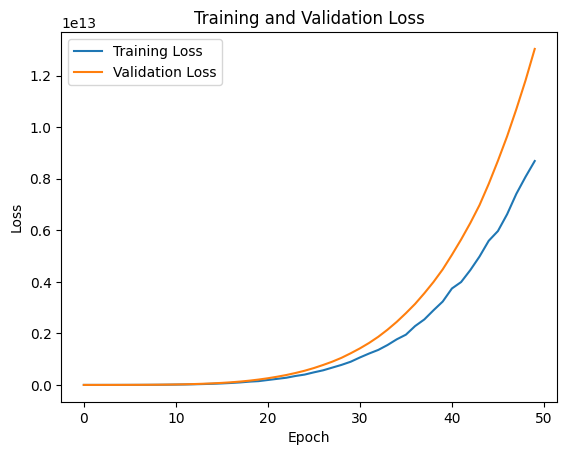

In [28]:
# Plot CNN loss curve
plot_loss_curves(cnn_model_history)

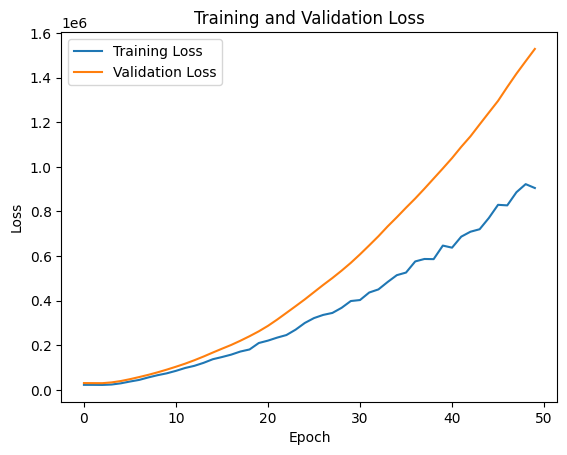

In [29]:
# Plot RNN loss curve
plot_loss_curves(rnn_lstm_model_history)

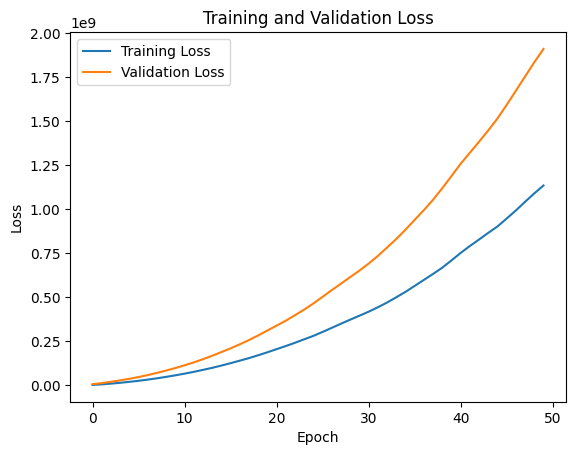

In [30]:
# Plot Transformer loss curve
plot_loss_curves(transformer_model_history)

# Data Augmentation

In [33]:
def extract_features(audio_files, data_dir, sr=22050, n_mfcc=13, max_length=1191, augmentation=None):
    features = []
    for file in audio_files:
        file_path = os.path.join(data_dir, file)
        if os.path.exists(file_path):
          # Load audio file
          audio, _ = librosa.load(file_path, sr=sr)

          # Apply data augmentation if specified
          if augmentation is not None:
              audio = augmentation(audio)

          # Extract MFCC features
          mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

          # Pad or truncate the features to a fixed length
          padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
        else:
          pass

        # Transpose to have time along the first axis
        features.append(padded_mfcc.T)
    return features

# Define data augmentation functions
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_stretch(audio, rate=1.2):
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def pitch_shift(audio, sr, n_steps=2):
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return augmented_audio

def speed_perturbation(audio, sr, speed_factor=1.2):
    augmented_audio = librosa.effects.time_stretch(audio, speed_factor)
    augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr, n_steps=0)
    return augmented_audio

# Example usage with augmentation
new_train_features = extract_features(train_files, data_dir, augmentation=lambda audio: add_noise(audio))
new_val_features = extract_features(val_files, data_dir, augmentation=lambda audio: time_stretch(audio))
new_test_features = extract_features(test_files, data_dir, augmentation=lambda audio: pitch_shift(audio, sr=22050))

# Add a channel dimension to input features
new_train_features = np.expand_dims(new_train_features, axis=-1)
new_val_features = np.expand_dims(new_val_features, axis=-1)
new_test_features = np.expand_dims(new_test_features, axis=-1)

In [34]:
# Define the input shape for the model
new_input_shape = new_train_features[0].shape # Remove the channel dimension
new_output_dim = np.array(train_texts_tokenized).shape[1]

In [35]:
# Build new cnn model
new_cnn_model = build_cnn_model(new_input_shape, new_output_dim)

In [36]:
# Build new rnn model
new_rnn_model = build_rnn_lstm_model(new_input_shape, new_output_dim)

In [37]:
# Build new transormer model
new_transformer_model = build_transformer_model(new_input_shape, new_output_dim)

In [38]:
# Reshape the features to add a channel dimension
new_train_features = np.reshape(new_train_features, (*new_train_features.shape, 1))
new_val_features = np.reshape(new_val_features, (*new_val_features.shape, 1))
new_test_features = np.reshape(new_test_features, (*new_test_features.shape, 1))

In [39]:
# Train the CNN model
new_cnn_model_history = new_cnn_model.fit(
    np.array(new_train_features), train_texts_tokenized,
    validation_data=(np.array(new_val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50
)

Epoch 1/50
4/4 [==============================] - 2s 337ms/step - loss: 1978789.8750 - accuracy: 0.0297 - val_loss: 18859632.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 1s 294ms/step - loss: 19582088.0000 - accuracy: 0.0099 - val_loss: 82553128.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 1s 319ms/step - loss: 65419208.0000 - accuracy: 0.0198 - val_loss: 233760496.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 2s 375ms/step - loss: 170062736.0000 - accuracy: 0.0099 - val_loss: 526408608.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 2s 376ms/step - loss: 379015904.0000 - accuracy: 0.0198 - val_loss: 1032050688.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 2s 364ms/step - loss: 689980928.0000 - accuracy: 0.0000e+00 - val_loss: 1836979200.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [========================

In [40]:
# Train the RNN model
new_rnn_model_history = new_rnn_model.fit(
    np.array(new_train_features), train_texts_tokenized,
    validation_data=(np.array(new_val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50
)

Epoch 1/50
4/4 [==============================] - 10s 2s/step - loss: 22266.6973 - accuracy: 0.0000e+00 - val_loss: 30236.2715 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 8s 2s/step - loss: 22209.4043 - accuracy: 0.0198 - val_loss: 30019.8984 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 8s 2s/step - loss: 22321.8320 - accuracy: 0.0099 - val_loss: 31166.7246 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 24254.3457 - accuracy: 0.0099 - val_loss: 34081.9727 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 29117.1504 - accuracy: 0.0297 - val_loss: 39674.0352 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 8s 2s/step - loss: 35224.3125 - accuracy: 0.0099 - val_loss: 47372.0273 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 8s 2s/step - loss: 43613.2969 - accuracy: 0.0099 - 

In [41]:
# Train the Transformer model
new_transformer_model_history = new_transformer_model.fit(
    np.array(new_train_features), train_texts_tokenized,
    validation_data=(np.array(new_val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50
)

Epoch 1/50
4/4 [==============================] - 15s 3s/step - loss: 894085.9375 - accuracy: 0.0000e+00 - val_loss: 5609542.5000 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 14s 3s/step - loss: 4114822.2500 - accuracy: 0.0099 - val_loss: 11367371.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 14s 3s/step - loss: 7423608.5000 - accuracy: 0.0099 - val_loss: 17550096.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 14s 3s/step - loss: 11228621.0000 - accuracy: 0.0099 - val_loss: 24875138.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 15s 4s/step - loss: 15841615.0000 - accuracy: 0.0099 - val_loss: 33205496.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 18s 4s/step - loss: 20722692.0000 - accuracy: 0.0099 - val_loss: 42184412.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 17s 4s/step - l

In [42]:
# Evaluate New CNN ASR model after augumentation
print("CNN ASR Model Evaluation:")
evaluate_model(new_cnn_model, np.array(new_test_features), test_texts_tokenized)

CNN ASR Model Evaluation:
1/1 [==============================] - 0s 126ms/step
----------------------------------------------------------------------------------------------------
predicted_0: 
true_0: aberanteɛ bi a wahyehyɛ ne ho kamakama n'afadze no yɛ kɔkɔɔ na akokɔ sradze ɔdze yɛn ɛtam na ɔdze apam trouser na coat beebi a ɔgyina no yɛ nsatɔnbea
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: 
true_1: abofra bi ne n'agya redidi nnuan bebree sisi table no so wɔde aduan rehyɛ n'agya ano n'agya jhyɛ spɛɛs na ɔno nso ayɛ ready regye aduan no afi ne ba no hɔ
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------

In [43]:
# Evaluate New RNN ASR model after augumentation
print("RNN ASR Model Evaluation:")
evaluate_model(new_rnn_model, np.array(new_test_features), test_texts_tokenized)

RNN ASR Model Evaluation:
1/1 [==============================] - 1s 853ms/step
----------------------------------------------------------------------------------------------------
predicted_0: 
true_0: mmɔfra baasa bi resaw nsu wa nsu a ɛtene mu wɔde kura buckets na wɔde resaw wɔn nyinaa de abɔ nsu no mu na bepɔw bi wɔ nsu no nkyɛn
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: 
true_1: akwadaa a ɔne ne papa ato pono a wɔredidi na watwa burodo ahyɛ ne papa anum a ne papa redi burodo no bi nso sisi hɔnom a ɛgu plate mu nkwadaa no bi ka wɔn ho a wɔredidi
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

In [43]:
# Evaluate New Transformer ASR model after augumentation
print("Transformer ASR Model Evaluation:")
evaluate_model(new_transformer_model, np.array(new_test_features), test_texts_tokenized)

Transformer ASR Model Evaluation:
1/1 [==============================] - 1s 966ms/step
----------------------------------------------------------------------------------------------------
predicted_0: wɔn
true_0: aberanteɛ bi a wahyehyɛ ne ho kamakama n'afadze no yɛ kɔkɔɔ na akokɔ sradze ɔdze yɛn ɛtam na ɔdze apam trouser na coat beebi a ɔgyina no yɛ nsatɔnbea
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: wɔn
true_1: abofra bi ne n'agya redidi nnuan bebree sisi table no so wɔde aduan rehyɛ n'agya ano n'agya jhyɛ spɛɛs na ɔno nso ayɛ ready regye aduan no afi ne ba no hɔ
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------

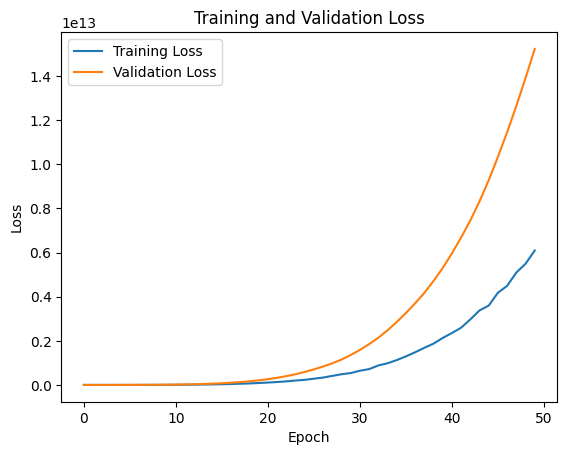

In [44]:
# Plot New CNN loss curve
plot_loss_curves(new_cnn_model_history)

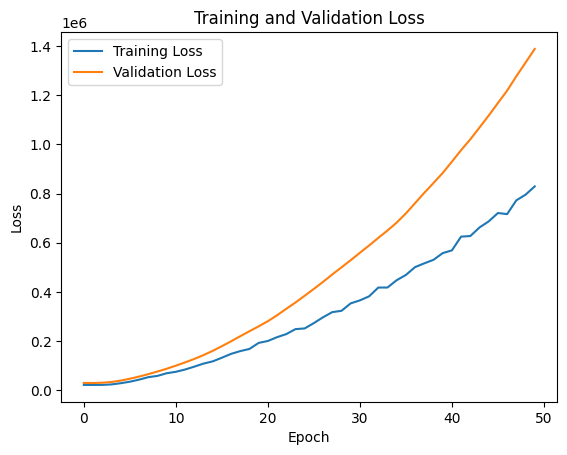

In [45]:
# Plot New RRN loss curve
plot_loss_curves(new_rnn_model_history)

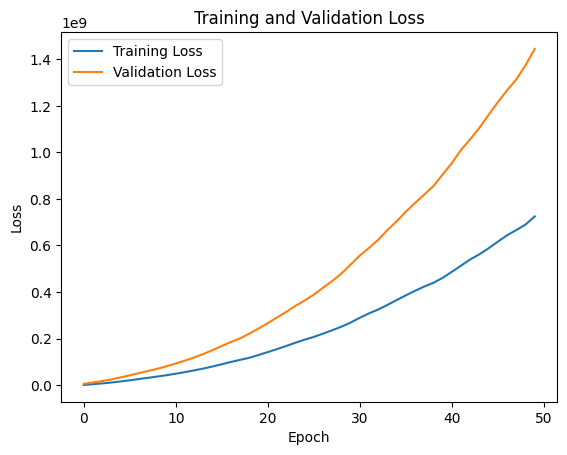

In [46]:
# Plot New Transformer loss curve
plot_loss_curves(new_transformer_model_history)

# Implementing attention mechanisms

In [47]:
def build_attention_model(input_shape, output_dim):
    inputs = layers.Input(shape=input_shape)

    # Reshape input to (sequence_length, num_features)
    x = layers.Reshape((input_shape[0], input_shape[1]))(inputs)

    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    # Transformer Encoder Layer with Multi-Head Self-Attention
    num_heads = 8
    ff_dim = 128
    transformer_block = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1] // num_heads)
    x = transformer_block(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Flatten the output of Conv1D
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [48]:
# Build new attention model
new_attention_model = build_attention_model(new_input_shape, new_output_dim)

In [49]:
# Define a callback to save the model
checkpoint_callback = ModelCheckpoint("datasets/checkpoint", save_best_only=True)

# Train the Transformer model
new_attention_history = new_attention_model.fit(
    np.array(new_train_features), train_texts_tokenized,
    validation_data=(np.array(new_val_features), val_texts_tokenized),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 459102.5000 - accuracy: 0.0297INFO:tensorflow:Assets written to: datasets\checkpoint\assets


INFO:tensorflow:Assets written to: datasets\checkpoint\assets


4/4 [==============================] - 8s 2s/step - loss: 459102.5000 - accuracy: 0.0297 - val_loss: 2194238.2500 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 2188677.0000 - accuracy: 0.0000e+00 - val_loss: 5569088.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 4s 986ms/step - loss: 4289113.0000 - accuracy: 0.0000e+00 - val_loss: 9301960.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 6618952.0000 - accuracy: 0.0000e+00 - val_loss: 13357915.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 4s 983ms/step - loss: 9239808.0000 - accuracy: 0.0000e+00 - val_loss: 17659226.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 4s 955ms/step - loss: 12032531.0000 - accuracy: 0.0000e+00 - val_loss: 22377632.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 4s 1s/step 

In [50]:
# Evaluate New Attention ASR model after augumentation
print("Attention ASR Model Evaluation:")
evaluate_model(new_attention_model, np.array(new_test_features), test_texts_tokenized)

Attention ASR Model Evaluation:


1/1 [==============================] - 0s 361ms/step
----------------------------------------------------------------------------------------------------
predicted_0: 
true_0: aberanteɛ bi a wahyehyɛ ne ho kamakama n'afadze no yɛ kɔkɔɔ na akokɔ sradze ɔdze yɛn ɛtam na ɔdze apam trouser na coat beebi a ɔgyina no yɛ nsatɔnbea
WER_0: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_1: 
true_1: abofra bi ne n'agya redidi nnuan bebree sisi table no so wɔde aduan rehyɛ n'agya ano n'agya jhyɛ spɛɛs na ɔno nso ayɛ ready regye aduan no afi ne ba no hɔ
WER_1: 1.0
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
predicted_2: 
true_2:

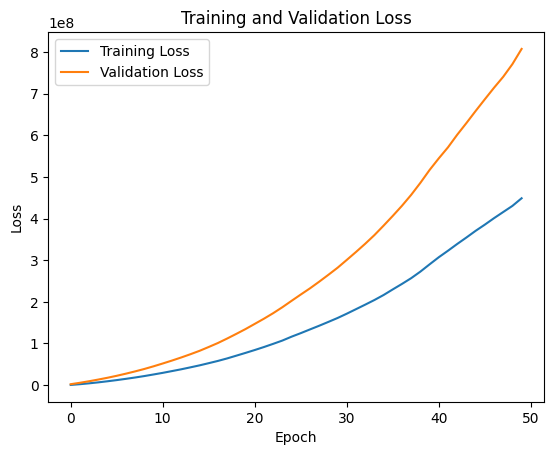

In [51]:
# Plot loss curves
plot_loss_curves(new_attention_history)


# Hyperparameter tuning

In [53]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor, KerasClassifier

# Create a KerasClassifier object
keras_classifier = KerasClassifier(model=build_attention_model(input_shape, output_dim), epochs=50, batch_size=32, verbose=1)

# Define hyperparameters to tune
param_grid = {
    'epochs': [50, 100, 150],
    'batch_size': [32, 64, 128],
}

# Create a TensorFlow Checkpoint
checkpoint = tf.train.Checkpoint(model=keras_classifier.model)

# Restore the model from the checkpoint (if available)
checkpoint.restore("datasets/checkpoint").expect_partial()

# Perform grid search
grid = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3)
grid_result = grid.fit(np.array(new_train_features), train_texts_tokenized)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Print best hyperparameters and performance
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpy89wruub\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpy89wruub\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp9u35fhct\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp9u35fhct\assets


Epoch 1/50
3/3 [==============================] - 3s 650ms/step - loss: 168366.7344 - accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 2s 659ms/step - loss: 1425231.5000 - accuracy: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 3s 677ms/step - loss: 2870945.2500 - accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 2s 674ms/step - loss: 4288044.0000 - accuracy: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 3s 686ms/step - loss: 5720447.5000 - accuracy: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 3s 667ms/step - loss: 7179067.0000 - accuracy: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 2s 669ms/step - loss: 8817488.0000 - accuracy: 0.0000e+00
Epoch 8/50
3/3 [==============================] - 2s 659ms/step - loss: 10436268.0000 - accuracy: 0.0000e+00
Epoch 9/50
3/3 [==============================] - 3s 671ms/step - loss: 12109688.0000 - accuracy: 0.0000e+00
Epoch 10/50
3/3 [==========

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpiu7rs7ry\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpiu7rs7ry\assets


Epoch 1/50
3/3 [==============================] - 5s 911ms/step - loss: 179084.5469 - accuracy: 0.0149
Epoch 2/50
3/3 [==============================] - 3s 894ms/step - loss: 1131702.5000 - accuracy: 0.0448
Epoch 3/50
3/3 [==============================] - 3s 913ms/step - loss: 2204509.5000 - accuracy: 0.0448
Epoch 4/50
3/3 [==============================] - 3s 890ms/step - loss: 3355214.0000 - accuracy: 0.0149
Epoch 5/50
3/3 [==============================] - 4s 927ms/step - loss: 4658624.5000 - accuracy: 0.0149
Epoch 6/50
3/3 [==============================] - 4s 929ms/step - loss: 6107050.0000 - accuracy: 0.0149
Epoch 7/50
3/3 [==============================] - 3s 872ms/step - loss: 7667873.5000 - accuracy: 0.0149
Epoch 8/50
3/3 [==============================] - 3s 713ms/step - loss: 9238590.0000 - accuracy: 0.0149
Epoch 9/50
3/3 [==============================] - 3s 757ms/step - loss: 10893331.0000 - accuracy: 0.0149
Epoch 10/50
3/3 [==============================] - 3s 760ms/step

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp75b13hoh\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp75b13hoh\assets


Epoch 1/50
3/3 [==============================] - 4s 722ms/step - loss: 206615.1562 - accuracy: 0.0147
Epoch 2/50
3/3 [==============================] - 3s 749ms/step - loss: 1129116.8750 - accuracy: 0.0147
Epoch 3/50
3/3 [==============================] - 3s 755ms/step - loss: 2267085.0000 - accuracy: 0.0147
Epoch 4/50
3/3 [==============================] - 3s 750ms/step - loss: 3571322.0000 - accuracy: 0.0147
Epoch 5/50
3/3 [==============================] - 3s 753ms/step - loss: 4987981.5000 - accuracy: 0.0147
Epoch 6/50
3/3 [==============================] - 3s 803ms/step - loss: 6459422.5000 - accuracy: 0.0147
Epoch 7/50
3/3 [==============================] - 3s 736ms/step - loss: 8037387.5000 - accuracy: 0.0147
Epoch 8/50
3/3 [==============================] - 3s 747ms/step - loss: 9702584.0000 - accuracy: 0.0147
Epoch 9/50
3/3 [==============================] - 3s 736ms/step - loss: 11519372.0000 - accuracy: 0.0147
Epoch 10/50
3/3 [==============================] - 3s 704ms/step

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpjy4rmf05\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpjy4rmf05\assets


Epoch 1/100
3/3 [==============================] - 4s 666ms/step - loss: 236454.4062 - accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 3s 683ms/step - loss: 1652806.7500 - accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 3s 680ms/step - loss: 3106518.7500 - accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 3s 676ms/step - loss: 4724813.5000 - accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 3s 749ms/step - loss: 6514182.5000 - accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 3s 715ms/step - loss: 8411083.0000 - accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 3s 741ms/step - loss: 10544140.0000 - accuracy: 0.0000e+00
Epoch 8/100
3/3 [==============================] - 3s 732ms/step - loss: 12876611.0000 - accuracy: 0.0000e+00
Epoch 9/100
3/3 [==============================] - 3s 684ms/step - loss: 15193185.0000 - accuracy: 0.0000e+00
Epoch 10/100
3/3 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpyobty851\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpyobty851\assets


Epoch 1/100
3/3 [==============================] - 4s 743ms/step - loss: 224288.4531 - accuracy: 0.0597
Epoch 2/100
3/3 [==============================] - 3s 720ms/step - loss: 1120162.0000 - accuracy: 0.0149
Epoch 3/100
3/3 [==============================] - 3s 807ms/step - loss: 2159777.2500 - accuracy: 0.0149
Epoch 4/100
3/3 [==============================] - 3s 877ms/step - loss: 3249401.2500 - accuracy: 0.0448
Epoch 5/100
3/3 [==============================] - 3s 879ms/step - loss: 4610604.5000 - accuracy: 0.0448
Epoch 6/100
3/3 [==============================] - 3s 697ms/step - loss: 6164113.0000 - accuracy: 0.0448
Epoch 7/100
3/3 [==============================] - 3s 680ms/step - loss: 7837599.0000 - accuracy: 0.0448
Epoch 8/100
3/3 [==============================] - 3s 732ms/step - loss: 9633813.0000 - accuracy: 0.0448
Epoch 9/100
3/3 [==============================] - 3s 690ms/step - loss: 11584091.0000 - accuracy: 0.0448
Epoch 10/100
3/3 [==============================] - 3s 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpcef1a8d9\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpcef1a8d9\assets


Epoch 1/100
3/3 [==============================] - 4s 700ms/step - loss: 170541.9688 - accuracy: 0.0147
Epoch 2/100
3/3 [==============================] - 3s 713ms/step - loss: 976279.2500 - accuracy: 0.0147
Epoch 3/100
3/3 [==============================] - 3s 713ms/step - loss: 1996099.7500 - accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 3s 752ms/step - loss: 3130361.0000 - accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 3s 715ms/step - loss: 4339060.0000 - accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 3s 698ms/step - loss: 5532886.5000 - accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 3s 714ms/step - loss: 6790261.5000 - accuracy: 0.0147
Epoch 8/100
3/3 [==============================] - 3s 705ms/step - loss: 8249333.5000 - accuracy: 0.0147
Epoch 9/100
3/3 [==============================] - 3s 710ms/step - loss: 9837102.0000 - accuracy: 0.0147
Epoch 10/100
3/3 [=======================

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpk65ucw_4\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpk65ucw_4\assets


Epoch 1/150
3/3 [==============================] - 4s 680ms/step - loss: 205163.4375 - accuracy: 0.0000e+00
Epoch 2/150
3/3 [==============================] - 3s 686ms/step - loss: 1633983.5000 - accuracy: 0.0000e+00
Epoch 3/150
3/3 [==============================] - 3s 696ms/step - loss: 3370084.5000 - accuracy: 0.0000e+00
Epoch 4/150
3/3 [==============================] - 3s 697ms/step - loss: 5321245.0000 - accuracy: 0.0000e+00
Epoch 5/150
3/3 [==============================] - 3s 690ms/step - loss: 7443027.5000 - accuracy: 0.0000e+00
Epoch 6/150
3/3 [==============================] - 3s 721ms/step - loss: 9585745.0000 - accuracy: 0.0000e+00
Epoch 7/150
3/3 [==============================] - 3s 683ms/step - loss: 11846314.0000 - accuracy: 0.0000e+00
Epoch 8/150
3/3 [==============================] - 3s 701ms/step - loss: 14281241.0000 - accuracy: 0.0000e+00
Epoch 9/150
3/3 [==============================] - 3s 691ms/step - loss: 16687014.0000 - accuracy: 0.0000e+00
Epoch 10/150
3/3 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpke6k_yz9\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpke6k_yz9\assets


Epoch 1/150
3/3 [==============================] - 4s 699ms/step - loss: 190562.0156 - accuracy: 0.0149
Epoch 2/150
3/3 [==============================] - 3s 686ms/step - loss: 1133033.0000 - accuracy: 0.0000e+00
Epoch 3/150
3/3 [==============================] - 3s 702ms/step - loss: 2213638.2500 - accuracy: 0.0000e+00
Epoch 4/150
3/3 [==============================] - 3s 682ms/step - loss: 3344396.5000 - accuracy: 0.0000e+00
Epoch 5/150
3/3 [==============================] - 3s 706ms/step - loss: 4458713.5000 - accuracy: 0.0000e+00
Epoch 6/150
3/3 [==============================] - 3s 695ms/step - loss: 5647450.5000 - accuracy: 0.0000e+00
Epoch 7/150
3/3 [==============================] - 3s 683ms/step - loss: 6932579.5000 - accuracy: 0.0000e+00
Epoch 8/150
3/3 [==============================] - 3s 712ms/step - loss: 8321175.0000 - accuracy: 0.0000e+00
Epoch 9/150
3/3 [==============================] - 3s 675ms/step - loss: 9877170.0000 - accuracy: 0.0000e+00
Epoch 10/150
3/3 [======

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpfmqluf7m\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpfmqluf7m\assets


Epoch 1/150
3/3 [==============================] - 4s 683ms/step - loss: 185733.4688 - accuracy: 0.0000e+00
Epoch 2/150
3/3 [==============================] - 3s 712ms/step - loss: 1061892.0000 - accuracy: 0.0000e+00
Epoch 3/150
3/3 [==============================] - 3s 702ms/step - loss: 2064858.6250 - accuracy: 0.0147
Epoch 4/150
3/3 [==============================] - 3s 699ms/step - loss: 3162248.2500 - accuracy: 0.0000e+00
Epoch 5/150
3/3 [==============================] - 3s 706ms/step - loss: 4445622.5000 - accuracy: 0.0147
Epoch 6/150
3/3 [==============================] - 3s 706ms/step - loss: 5838800.0000 - accuracy: 0.0147
Epoch 7/150
3/3 [==============================] - 3s 697ms/step - loss: 7380043.5000 - accuracy: 0.0147
Epoch 8/150
3/3 [==============================] - 3s 707ms/step - loss: 8981976.0000 - accuracy: 0.0147
Epoch 9/150
3/3 [==============================] - 3s 704ms/step - loss: 10663253.0000 - accuracy: 0.0147
Epoch 10/150
3/3 [=========================

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp5a9u7i6g\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp5a9u7i6g\assets


Epoch 1/50
2/2 [==============================] - 4s 171ms/step - loss: 46209.5664 - accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 3s 173ms/step - loss: 899213.0000 - accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 2s 166ms/step - loss: 1820366.8750 - accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 2s 171ms/step - loss: 2784761.2500 - accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 3s 180ms/step - loss: 3839220.2500 - accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 3s 174ms/step - loss: 5056901.5000 - accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 3s 176ms/step - loss: 6364677.5000 - accuracy: 0.0000e+00
Epoch 8/50
2/2 [==============================] - 3s 173ms/step - loss: 7741709.0000 - accuracy: 0.0000e+00
Epoch 9/50
2/2 [==============================] - 3s 178ms/step - loss: 9138615.0000 - accuracy: 0.0000e+00
Epoch 10/50
2/2 [==============

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpexzlo7pm\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpexzlo7pm\assets


Epoch 1/50
2/2 [==============================] - 4s 176ms/step - loss: 38248.2930 - accuracy: 0.0299
Epoch 2/50
2/2 [==============================] - 3s 179ms/step - loss: 534696.7500 - accuracy: 0.0149
Epoch 3/50
2/2 [==============================] - 3s 179ms/step - loss: 1184596.6250 - accuracy: 0.0149
Epoch 4/50
2/2 [==============================] - 2s 176ms/step - loss: 1819237.3750 - accuracy: 0.0149
Epoch 5/50
2/2 [==============================] - 2s 178ms/step - loss: 2426995.5000 - accuracy: 0.0149
Epoch 6/50
2/2 [==============================] - 2s 175ms/step - loss: 3106497.0000 - accuracy: 0.0149
Epoch 7/50
2/2 [==============================] - 2s 176ms/step - loss: 3872813.0000 - accuracy: 0.0149
Epoch 8/50
2/2 [==============================] - 3s 212ms/step - loss: 4655748.0000 - accuracy: 0.0149
Epoch 9/50
2/2 [==============================] - 2s 174ms/step - loss: 5421089.5000 - accuracy: 0.0149
Epoch 10/50
2/2 [==============================] - 3s 182ms/step - 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmplw2b6c2h\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmplw2b6c2h\assets


Epoch 1/50
2/2 [==============================] - 3s 219ms/step - loss: 44803.3164 - accuracy: 0.0147
Epoch 2/50
2/2 [==============================] - 3s 236ms/step - loss: 664931.0625 - accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 3s 213ms/step - loss: 1317729.6250 - accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 3s 218ms/step - loss: 2055930.8750 - accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 3s 241ms/step - loss: 2869668.2500 - accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 3s 224ms/step - loss: 3800791.7500 - accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 3s 228ms/step - loss: 4803215.0000 - accuracy: 0.0000e+00
Epoch 8/50
2/2 [==============================] - 3s 231ms/step - loss: 5879097.5000 - accuracy: 0.0000e+00
Epoch 9/50
2/2 [==============================] - 3s 218ms/step - loss: 6974654.0000 - accuracy: 0.0000e+00
Epoch 10/50
2/2 [==================

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpz5w4rpfz\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpz5w4rpfz\assets


Epoch 1/100
2/2 [==============================] - 4s 174ms/step - loss: 35899.2266 - accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 3s 193ms/step - loss: 617613.6250 - accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 3s 176ms/step - loss: 1258035.3750 - accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 3s 182ms/step - loss: 1986470.1250 - accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 2s 170ms/step - loss: 2753381.7500 - accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 3s 174ms/step - loss: 3588349.5000 - accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 3s 183ms/step - loss: 4492343.0000 - accuracy: 0.0000e+00
Epoch 8/100
2/2 [==============================] - 3s 169ms/step - loss: 5516635.0000 - accuracy: 0.0000e+00
Epoch 9/100
2/2 [==============================] - 2s 178ms/step - loss: 6634708.5000 - accuracy: 0.0000e+00
Epoch 10/100
2/2 [====

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpbc6ch_ec\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpbc6ch_ec\assets


Epoch 1/100
2/2 [==============================] - 3s 179ms/step - loss: 38049.0898 - accuracy: 0.0149
Epoch 2/100
2/2 [==============================] - 2s 173ms/step - loss: 505395.1562 - accuracy: 0.0597
Epoch 3/100
2/2 [==============================] - 2s 189ms/step - loss: 1031116.3125 - accuracy: 0.0597
Epoch 4/100
2/2 [==============================] - 3s 172ms/step - loss: 1530609.1250 - accuracy: 0.0448
Epoch 5/100
2/2 [==============================] - 2s 186ms/step - loss: 2295970.5000 - accuracy: 0.0448
Epoch 6/100
2/2 [==============================] - 3s 176ms/step - loss: 3145119.5000 - accuracy: 0.0448
Epoch 7/100
2/2 [==============================] - 3s 177ms/step - loss: 3995059.7500 - accuracy: 0.0448
Epoch 8/100
2/2 [==============================] - 2s 169ms/step - loss: 4868814.5000 - accuracy: 0.0448
Epoch 9/100
2/2 [==============================] - 3s 180ms/step - loss: 5788357.5000 - accuracy: 0.0448
Epoch 10/100
2/2 [==============================] - 2s 171

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpdrc_zq8b\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpdrc_zq8b\assets


Epoch 1/100
2/2 [==============================] - 4s 223ms/step - loss: 44195.3633 - accuracy: 0.0147
Epoch 2/100
2/2 [==============================] - 3s 228ms/step - loss: 721674.1875 - accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 3s 222ms/step - loss: 1568005.0000 - accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 3s 225ms/step - loss: 2562847.0000 - accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 3s 220ms/step - loss: 3454794.0000 - accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 3s 222ms/step - loss: 4340050.0000 - accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 3s 222ms/step - loss: 5271630.0000 - accuracy: 0.0000e+00
Epoch 8/100
2/2 [==============================] - 3s 220ms/step - loss: 6280767.0000 - accuracy: 0.0000e+00
Epoch 9/100
2/2 [==============================] - 3s 218ms/step - loss: 7336448.5000 - accuracy: 0.0000e+00
Epoch 10/100
2/2 [========

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp8i9ihg6q\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp8i9ihg6q\assets


Epoch 1/150
2/2 [==============================] - 3s 176ms/step - loss: 47899.8203 - accuracy: 0.0000e+00
Epoch 2/150
2/2 [==============================] - 2s 172ms/step - loss: 675239.5625 - accuracy: 0.0448
Epoch 3/150
2/2 [==============================] - 3s 181ms/step - loss: 1523784.7500 - accuracy: 0.0448
Epoch 4/150
2/2 [==============================] - 3s 181ms/step - loss: 2495660.5000 - accuracy: 0.0448
Epoch 5/150
2/2 [==============================] - 3s 184ms/step - loss: 3412588.7500 - accuracy: 0.0448
Epoch 6/150
2/2 [==============================] - 2s 184ms/step - loss: 4364420.5000 - accuracy: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 3s 177ms/step - loss: 5422894.5000 - accuracy: 0.0000e+00
Epoch 8/150
2/2 [==============================] - 2s 183ms/step - loss: 6519927.5000 - accuracy: 0.0000e+00
Epoch 9/150
2/2 [==============================] - 3s 178ms/step - loss: 7641061.0000 - accuracy: 0.0000e+00
Epoch 10/150
2/2 [====================

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpodff9zdo\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpodff9zdo\assets


Epoch 1/150
2/2 [==============================] - 3s 175ms/step - loss: 38806.8164 - accuracy: 0.0000e+00
Epoch 2/150
2/2 [==============================] - 3s 174ms/step - loss: 667506.6250 - accuracy: 0.0448
Epoch 3/150
2/2 [==============================] - 2s 178ms/step - loss: 1390143.7500 - accuracy: 0.0448
Epoch 4/150
2/2 [==============================] - 2s 178ms/step - loss: 2224295.2500 - accuracy: 0.0448
Epoch 5/150
2/2 [==============================] - 3s 184ms/step - loss: 3115875.5000 - accuracy: 0.0448
Epoch 6/150
2/2 [==============================] - 3s 175ms/step - loss: 4074182.2500 - accuracy: 0.0448
Epoch 7/150
2/2 [==============================] - 2s 184ms/step - loss: 5001600.0000 - accuracy: 0.0448
Epoch 8/150
2/2 [==============================] - 2s 171ms/step - loss: 5953116.5000 - accuracy: 0.0448
Epoch 9/150
2/2 [==============================] - 2s 192ms/step - loss: 6913463.5000 - accuracy: 0.0448
Epoch 10/150
2/2 [==============================] - 3s

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp9unk_x8h\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp9unk_x8h\assets


Epoch 1/150
2/2 [==============================] - 4s 225ms/step - loss: 39985.2461 - accuracy: 0.0441
Epoch 2/150
2/2 [==============================] - 3s 221ms/step - loss: 618920.2500 - accuracy: 0.0588
Epoch 3/150
2/2 [==============================] - 3s 218ms/step - loss: 1279319.5000 - accuracy: 0.0588
Epoch 4/150
2/2 [==============================] - 3s 225ms/step - loss: 1989782.6250 - accuracy: 0.0588
Epoch 5/150
2/2 [==============================] - 3s 222ms/step - loss: 2713337.2500 - accuracy: 0.0588
Epoch 6/150
2/2 [==============================] - 2s 228ms/step - loss: 3460577.0000 - accuracy: 0.0588
Epoch 7/150
2/2 [==============================] - 3s 220ms/step - loss: 4183745.5000 - accuracy: 0.0588
Epoch 8/150
2/2 [==============================] - 3s 231ms/step - loss: 4998588.0000 - accuracy: 0.0588
Epoch 9/150
2/2 [==============================] - 3s 226ms/step - loss: 5925090.0000 - accuracy: 0.0588
Epoch 10/150
2/2 [==============================] - 3s 234

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpzb3sayis\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpzb3sayis\assets


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 27928.8965 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 381917.6562 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 902672.2500 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 1399060.1250 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 1959604.0000 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 2499965.2500 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 3022317.7500 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 3540410.2500 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 4050349.2500 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 2s 2s/st

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmps0_rypyv\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmps0_rypyv\assets


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 26339.8281 - accuracy: 0.0149
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 358388.5312 - accuracy: 0.0299
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 741118.0000 - accuracy: 0.0299
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 1180901.3750 - accuracy: 0.0149
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 1671529.8750 - accuracy: 0.0149
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 2181631.2500 - accuracy: 0.0149
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 2719543.7500 - accuracy: 0.0149
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 3285155.0000 - accuracy: 0.0149
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 3840065.7500 - accuracy: 0.0149
Epoch 10/50
1/1 [==============================] - 2s 2s/step - loss: 4416688.5000 - accuracy: 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmplk_5gz1v\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmplk_5gz1v\assets


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 22704.0117 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 269466.9375 - accuracy: 0.0147
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 641852.9375 - accuracy: 0.0147
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 1018980.0000 - accuracy: 0.0147
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 1424894.6250 - accuracy: 0.0147
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 1867055.1250 - accuracy: 0.0147
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 2324500.5000 - accuracy: 0.0147
Epoch 8/50
1/1 [==============================] - 3s 3s/step - loss: 2798728.0000 - accuracy: 0.0147
Epoch 9/50
1/1 [==============================] - 3s 3s/step - loss: 3258886.0000 - accuracy: 0.0147
Epoch 10/50
1/1 [==============================] - 3s 3s/step - loss: 3751713.5000 - accura

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpd2u8thda\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpd2u8thda\assets


Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 28074.3828 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 381186.5938 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 908171.8125 - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 1452538.2500 - accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 2042435.3750 - accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 2670452.2500 - accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 3288226.7500 - accuracy: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 3s 3s/step - loss: 3920082.5000 - accuracy: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 4584696.5000 - accuracy: 0.0000e+00
Epoch 10/100
1/1 [==============================] 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpcejcc97p\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpcejcc97p\assets


Epoch 1/100


1/1 [==============================] - 4s 4s/step - loss: 26236.9062 - accuracy: 0.0149
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 274009.6250 - accuracy: 0.0299
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 558680.2500 - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 884640.3125 - accuracy: 0.0149
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1249080.3750 - accuracy: 0.0149
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 1641869.5000 - accuracy: 0.0149
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 2040308.0000 - accuracy: 0.0149
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 2444755.5000 - accuracy: 0.0149
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 2870052.0000 - accuracy: 0.0149
Epoch 10/100
1/1 [==============================] - 2s 2s/step - loss: 3292582.7500 - accuracy:

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp44ubzxbs\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp44ubzxbs\assets


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 22917.8262 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 278297.3438 - accuracy: 0.0588
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 598320.8750 - accuracy: 0.0588
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 927006.1250 - accuracy: 0.0588
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1300153.0000 - accuracy: 0.0588
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 1688199.7500 - accuracy: 0.0588
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 2109563.7500 - accuracy: 0.0588
Epoch 8/100
1/1 [==============================] - 3s 3s/step - loss: 2525831.0000 - accuracy: 0.0588
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 2971922.0000 - accuracy: 0.0588
Epoch 10/100
1/1 [==============================] - 2s 2s/step - loss: 3425475.2500

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpqcqi8y81\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpqcqi8y81\assets


Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 28264.4629 - accuracy: 0.0149
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 333371.9375 - accuracy: 0.0000e+00
Epoch 3/150
1/1 [==============================] - 2s 2s/step - loss: 733991.6250 - accuracy: 0.0000e+00
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 1162485.0000 - accuracy: 0.0000e+00
Epoch 5/150
1/1 [==============================] - 3s 3s/step - loss: 1635145.5000 - accuracy: 0.0000e+00
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 2137695.2500 - accuracy: 0.0000e+00
Epoch 7/150
1/1 [==============================] - 2s 2s/step - loss: 2629565.2500 - accuracy: 0.0000e+00
Epoch 8/150
1/1 [==============================] - 2s 2s/step - loss: 3108754.7500 - accuracy: 0.0000e+00
Epoch 9/150
1/1 [==============================] - 2s 2s/step - loss: 3610785.5000 - accuracy: 0.0000e+00
Epoch 10/150
1/1 [==============================] - 2s

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp87uyvc_s\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmp87uyvc_s\assets


Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 26203.3477 - accuracy: 0.0149
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 261774.7500 - accuracy: 0.0299
Epoch 3/150
1/1 [==============================] - 2s 2s/step - loss: 569928.6250 - accuracy: 0.0149
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 932988.3750 - accuracy: 0.0149
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 1319200.0000 - accuracy: 0.0149
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 1733244.2500 - accuracy: 0.0149
Epoch 7/150
1/1 [==============================] - 2s 2s/step - loss: 2177232.0000 - accuracy: 0.0149
Epoch 8/150
1/1 [==============================] - 2s 2s/step - loss: 2638246.5000 - accuracy: 0.0149
Epoch 9/150
1/1 [==============================] - 2s 2s/step - loss: 3105026.2500 - accuracy: 0.0149
Epoch 10/150
1/1 [==============================] - 2s 2s/step - loss: 3582657.7500 - a

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpx10gbiq8\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpx10gbiq8\assets


Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 22941.8867 - accuracy: 0.0147
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 278534.3438 - accuracy: 0.0147
Epoch 3/150
1/1 [==============================] - 2s 2s/step - loss: 646775.0625 - accuracy: 0.0147
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 1030276.8125 - accuracy: 0.0147
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 1488361.1250 - accuracy: 0.0147
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 1985483.2500 - accuracy: 0.0147
Epoch 7/150
1/1 [==============================] - 2s 2s/step - loss: 2460701.2500 - accuracy: 0.0147
Epoch 8/150
1/1 [==============================] - 2s 2s/step - loss: 2968461.2500 - accuracy: 0.0147
Epoch 9/150
1/1 [==============================] - 2s 2s/step - loss: 3473531.2500 - accuracy: 0.0147
Epoch 10/150
1/1 [==============================] - 2s 2s/step - loss: 4013914.2500 - 

d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1111, in score
    y_pred = self.predict(X)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\wrappers.py", line 1051, in predict
    y_pred = self.target_encoder_.inverse_transform(y_pred)
  File "d:\projects\machine_learning\asr\venv\lib\site-packages\scikeras\utils\transformers.py", line 274, in 

INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpqg9qtnzf\assets


INFO:tensorflow:Assets written to: C:\Users\delijah\AppData\Local\Temp\tmpqg9qtnzf\assets


Epoch 1/50
4/4 [==============================] - 5s 894ms/step - loss: 371404.5000 - accuracy: 0.0198
Epoch 2/50
4/4 [==============================] - 4s 888ms/step - loss: 1804718.2500 - accuracy: 0.0297
Epoch 3/50
4/4 [==============================] - 4s 880ms/step - loss: 3659024.7500 - accuracy: 0.0396
Epoch 4/50
4/4 [==============================] - 4s 884ms/step - loss: 5651447.0000 - accuracy: 0.0396
Epoch 5/50
4/4 [==============================] - 4s 900ms/step - loss: 7803483.0000 - accuracy: 0.0396
Epoch 6/50
4/4 [==============================] - 4s 894ms/step - loss: 10092972.0000 - accuracy: 0.0396
Epoch 7/50
4/4 [==============================] - 4s 938ms/step - loss: 12617903.0000 - accuracy: 0.0396
Epoch 8/50
4/4 [==============================] - 4s 893ms/step - loss: 15234736.0000 - accuracy: 0.0396
Epoch 9/50
4/4 [==============================] - 4s 902ms/step - loss: 18009764.0000 - accuracy: 0.0396
Epoch 10/50
4/4 [==============================] - 5s 1s/step